## Question: 
Predicting played hours based on the following predictor variables:  experience level, age and gender

In [6]:
#load packages
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(ggplot2)
library(RColorBrewer)

In [7]:
#loading data
players <- read_csv("players.csv")
head(players)
tail(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Amateur,TRUE,644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6,0.0,Rhys,Male,20
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [19]:
#tidy data
players_tidy <- players |> 

# Select out the hashedEmail and name column vectors as they are identifiers and contain no predictive information.
                select(-hashedEmail, -name) |> 

#Convert subscribe, experience, and gender character variables to factor variables so that R can treat them as categorical variables.
  mutate(subscribe_fct=as_factor(subscribe)) |> 
  mutate(experience_fct=as_factor(experience)) |>
  mutate(gender_fct=as_factor(gender)) |>

#Filter out the played_hours variable and select only those who have >0 gameplay hours. Zero-hour players are non-contributors and do not contribute to the goal of identifying high-engagement users.
                filter(played_hours>0) |> 

#Remove rows with missing Age, as leaving NA values leads to loss of rows silently and inconsistencies in model prediction.
         filter(!is.na(Age)) |>   

#To deal with extreme outliers in played_hours, transform highly skewed values into log as it compresses the large values, which makes the distribution closer to normal and stabilizes variance. 
         mutate(played_hours_log = log(played_hours + 1))
               

#remove non fct columns to prevent multicollinearlity when performing multivariable linear regression and to ease visualisation of the dataset.

players_clean<- players_tidy |> drop_na(played_hours_log, experience_fct, gender_fct, Age)|>select(experience_fct, subscribe_fct, gender_fct, Age, played_hours_log)

head(players_clean)
tail(players_clean)

experience_fct,subscribe_fct,gender_fct,Age,played_hours_log
<fct>,<fct>,<fct>,<dbl>,<dbl>
Pro,TRUE,Male,9,3.44361810
Veteran,TRUE,Male,17,1.56861592
Amateur,TRUE,Female,21,0.53062825
Regular,TRUE,Male,21,0.09531018
Amateur,TRUE,Male,47,0.09531018
Veteran,TRUE,Female,23,0.95551145


experience_fct,subscribe_fct,gender_fct,Age,played_hours_log
<fct>,<fct>,<fct>,<dbl>,<dbl>
Amateur,TRUE,Male,22,3.49650756
Pro,FALSE,Male,17,0.99325177
Regular,FALSE,Male,18,0.09531018
Veteran,TRUE,Female,44,0.09531018
Veteran,FALSE,Male,22,0.26236426
Amateur,FALSE,Male,17,1.19392247


## Using linear regression model

In [25]:
players_split <- initial_split(players_clean, prop=0.75, strata = experience_fct)
players_train <- training(players_split)
players_test <- testing(players_split)

players_spec <- linear_reg()|>
    set_engine("lm")|>
    set_mode("regression")

players_recipe <- recipe(played_hours_log ~ experience_fct + gender_fct + Age, data=players_train)|>
  step_novel(all_nominal_predictors()) |> 
  step_dummy(all_nominal_predictors())

#step_novel() tells tidymodels: If new factor levels appear during prediction, put them in a special "novel" bucket instead of erroring.

players_fit <- workflow() |>
    add_recipe(players_recipe)|>
    add_model(players_spec)|>
    fit(data=players_train)
players_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_novel()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
                 (Intercept)                           Age  
                     1.14907                      -0.02037  
      experience_fct_Veteran        experience_fct_Amateur  
                    -0.61487                       0.14870  
      experience_fct_Regular       experience_fct_Beginner  
                     0.60219                      -0.42147  
          experience_fct_new             gender_fct_Female  
                          NA                       0.75765  
       gender_fct_Non.binary  gender_fct_Prefer.not.to.say  
                     1.41509                       0.23

In [26]:
extract_fit_parsnip(players_fit)
tidy(players_fit)

parsnip model object


Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
                 (Intercept)                           Age  
                     1.14907                      -0.02037  
      experience_fct_Veteran        experience_fct_Amateur  
                    -0.61487                       0.14870  
      experience_fct_Regular       experience_fct_Beginner  
                     0.60219                      -0.42147  
          experience_fct_new             gender_fct_Female  
                          NA                       0.75765  
       gender_fct_Non.binary  gender_fct_Prefer.not.to.say  
                     1.41509                       0.23623  
          gender_fct_Agender       gender_fct_Two.Spirited  
                     2.61854                      -0.61497  
            gender_fct_Other                gender_fct_new  
                          NA                            NA  


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.1490716,0.46994044,2.4451431,0.01699862
Age,-0.0203722,0.01667597,-1.2216500,0.22593831
experience_fct_Veteran,-0.6148682,0.50081454,-1.2277362,0.22365856
experience_fct_Amateur,0.1487019,0.47580197,0.3125289,0.75556776
experience_fct_Regular,0.6021946,0.52119979,1.1554007,0.25185504
experience_fct_Beginner,-0.4214741,0.52734634,-0.7992358,0.42685739
experience_fct_new,NA,NA,NA,NA
gender_fct_Female,0.7576463,0.33753510,2.2446446,0.02795350
gender_fct_Non.binary,1.4150893,0.63449435,2.2302630,0.02893806


In [27]:
players_test_result <- players_fit|>
    predict(players_test)|>
    bind_cols(players_test)|>
    metrics(truth=played_hours_log, estimate=.pred)
players_test_result

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response", :
“prediction from rank-deficient fit; consider predict(., rankdeficient="NA")”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.4376387244
rsq,standard,0.0004386257
mae,standard,1.0569724805


Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response", :
“prediction from rank-deficient fit; consider predict(., rankdeficient="NA")”


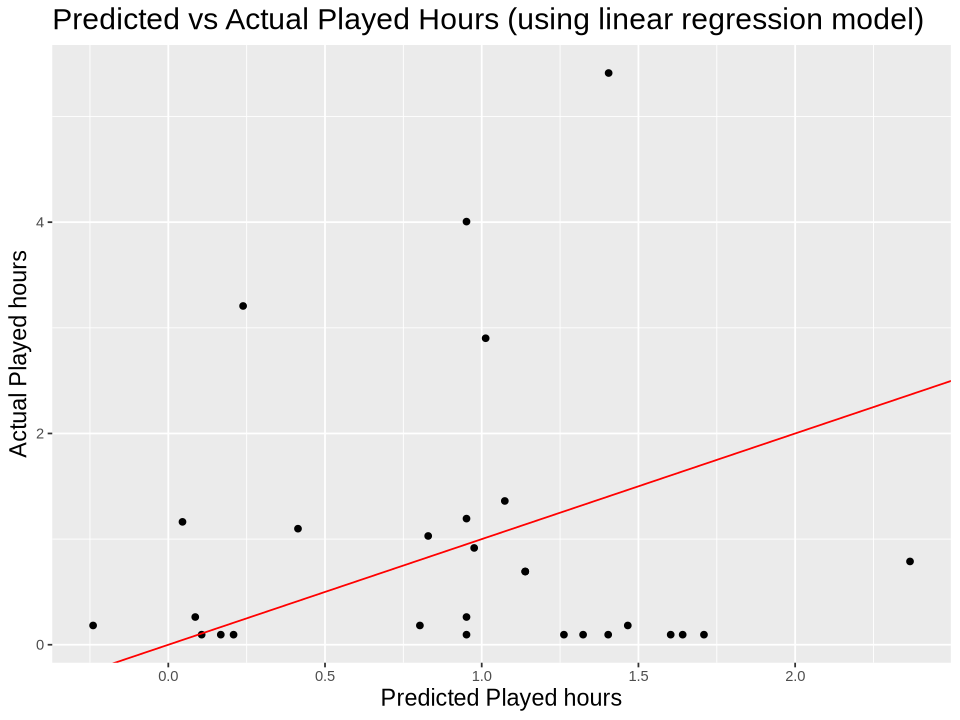

In [28]:
options(repr.plot.width = 8, repr.plot.height = 6)
players_test_visual <- players_fit |>
    predict(players_test) |> 
    bind_cols(players_test) |>
    ggplot(aes(x = .pred, y = played_hours_log)) +
    geom_point() +
    geom_abline(slope = 1, intercept = 0, color="red") +
    labs(x = "Predicted Played hours", y = "Actual Played hours")+
    theme(plot.title = element_text(size = 18),
    axis.title = element_text(size = 14))+
    ggtitle("Predicted vs Actual Played Hours (using linear regression model)")
players_test_visual

## Using knn model

In [29]:
glimpse(players_clean)

Rows: 109
Columns: 5
$ experience_fct   <fct> Pro, Veteran, Amateur, Regular, Amateur, Veteran, Beg…
$ subscribe_fct    <fct> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE,…
$ gender_fct       <fct> Male, Male, Female, Male, Male, Female, Female, Male,…
$ Age              <dbl> 9, 17, 21, 21, 47, 23, 25, 22, 17, 17, 19, 58, 17, 17…
$ played_hours_log <dbl> 3.44361810, 1.56861592, 0.53062825, 0.09531018, 0.095…


In [36]:
set.seed(123)
players_split <- initial_split(players_clean, prop = 0.75, strata = experience_fct)
players_train <- training(players_split)
players_test  <- testing(players_split)

players_recipe <- recipe(played_hours_log ~ experience_fct + gender_fct + Age, data = players_train) |>
   step_novel(all_nominal_predictors()) |> 
  step_dummy(all_nominal_predictors())             

lm_spec <- linear_reg()|>
  set_engine("lm") |>
  set_mode("regression")

lm_workflow <- workflow()|>
  add_recipe(players_recipe) |>
  add_model(lm_spec)

lm_fit <- lm_workflow|>
    fit(data = players_train)

lm_predictions <- predict(lm_fit, new_data = players_test) |>
  bind_cols(players_test|>
            select(played_hours_log))

lm_metrics <- lm_predictions |>
  metrics(truth = played_hours_log, estimate = .pred)
lm_metrics

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response", :
“prediction from rank-deficient fit; consider predict(., rankdeficient="NA")”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.264216e+00
rsq,standard,6.267186e-07
mae,standard,9.215690e-01


In [45]:
rmse(lm_predictions, played_hours_log, .pred)
mae(lm_predictions, played_hours_log, .pred)
rsq(lm_predictions, played_hours_log, .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.264216


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mae,standard,0.921569


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,6.267186e-07


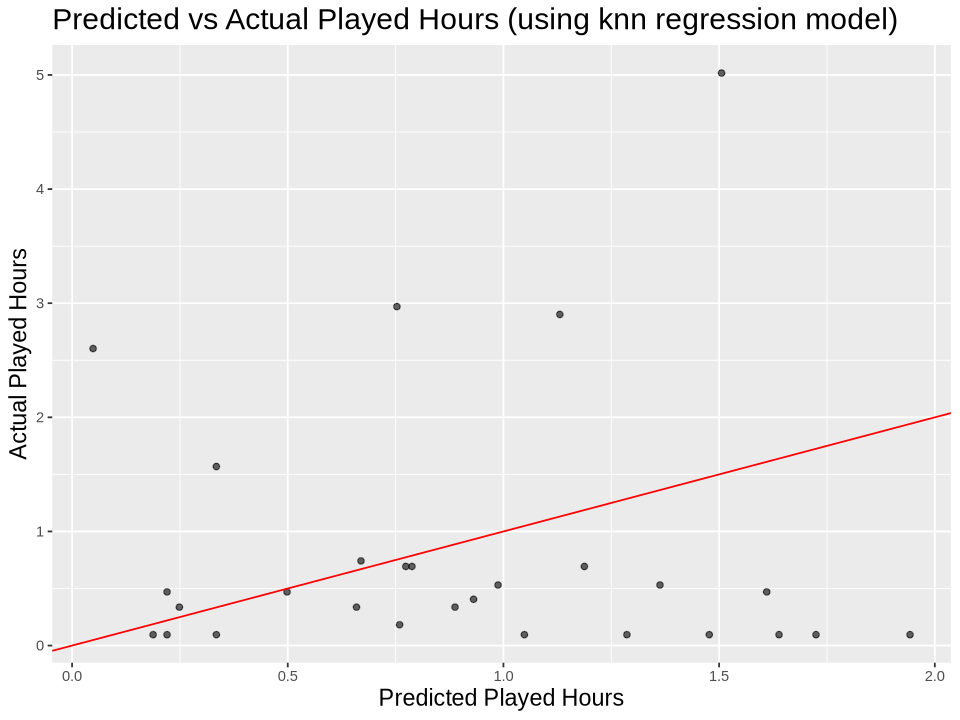

In [38]:
lm_visualization <- ggplot(lm_predictions, aes(x = .pred, y = played_hours_log)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, color = "red") +
  labs(title = "Predicted vs Actual Played Hours",
       x = "Predicted Played Hours",
       y = "Actual Played Hours")+
    theme(plot.title = element_text(size = 18),
        axis.title = element_text(size = 14))+
        ggtitle("Predicted vs Actual Played Hours (using knn regression model)")
lm_visualization

**Residual Plot**

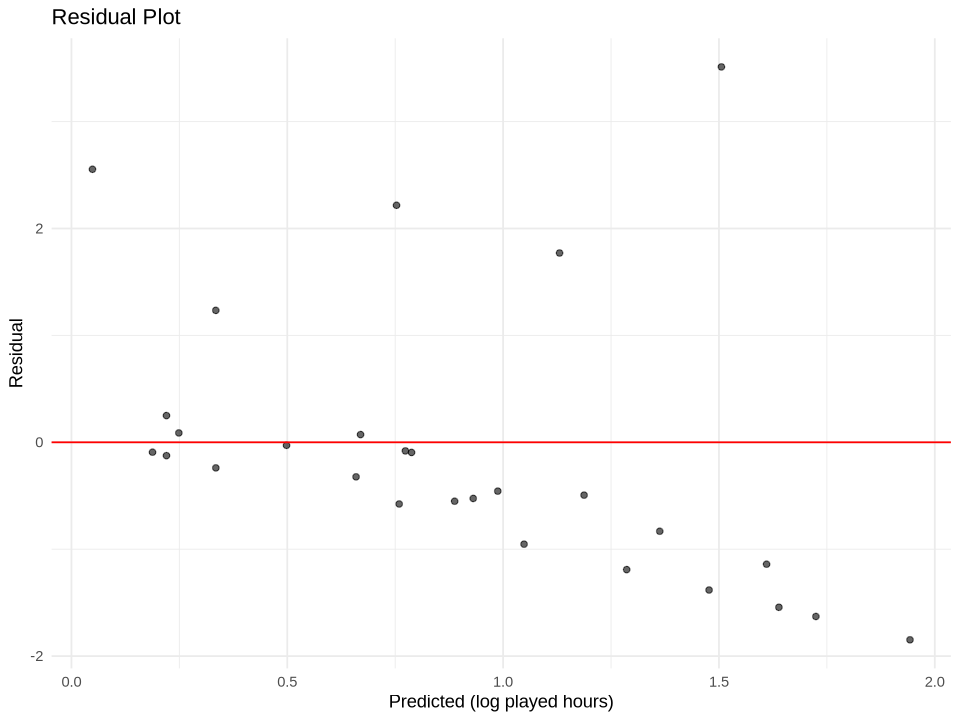

In [42]:
residual_plot<- lm_predictions |>
  mutate(residual = played_hours_log - .pred) |>
  ggplot(aes(x = .pred, y = residual)) +
  geom_point(alpha = 0.6) +
  geom_hline(yintercept = 0, color = "red") +
  labs(
    x = "Predicted (log played hours)",
    y = "Residual",
    title = "Residual Plot"
  ) +
  theme_minimal()

residual_plot

In [43]:
library(broom)

model_details <- tidy(players_fit)
model_details

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.1490716,0.46994044,2.4451431,0.01699862
Age,-0.0203722,0.01667597,-1.2216500,0.22593831
experience_fct_Veteran,-0.6148682,0.50081454,-1.2277362,0.22365856
experience_fct_Amateur,0.1487019,0.47580197,0.3125289,0.75556776
experience_fct_Regular,0.6021946,0.52119979,1.1554007,0.25185504
experience_fct_Beginner,-0.4214741,0.52734634,-0.7992358,0.42685739
experience_fct_new,NA,NA,NA,NA
gender_fct_Female,0.7576463,0.33753510,2.2446446,0.02795350
gender_fct_Non.binary,1.4150893,0.63449435,2.2302630,0.02893806
